In [1]:
import numpy as np 
import matplotlib.pyplot as plt


0.004060308
-0.004060308
(array([  139,   144,   148, ..., 26653, 26655, 26658]),)


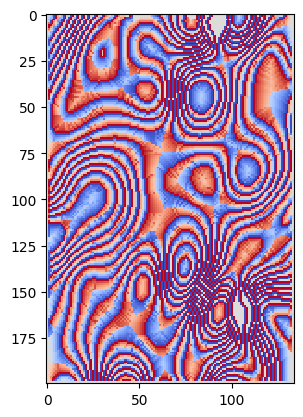

In [3]:
comp = np.fromfile("compensation_map.f32",dtype=np.float32).reshape(200, 134)
plt.imshow(comp, cmap='coolwarm', interpolation='nearest')
print(comp.max())
print(comp.min())
print(np.where(comp.flatten() == comp.max()))

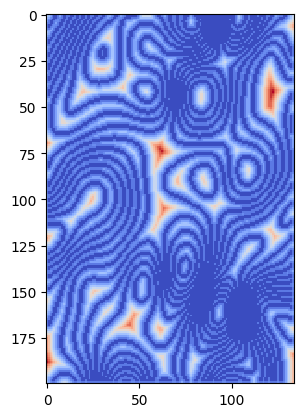

In [23]:
distance_array = np.fromfile("distance_array.f64",dtype=np.float64).reshape(200, 134) 
plt.imshow(distance_array, cmap='coolwarm', interpolation='nearest')

0.004060348
-0.004060348
(array([ 3462839,  3462840,  3462841, ..., 37597655, 37597656, 37597657]),)


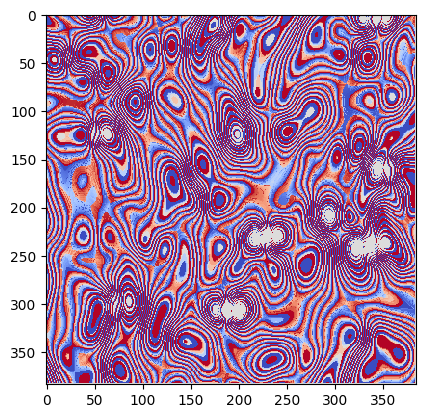

In [8]:
comp = np.fromfile("compensation_map.f32",dtype=np.float32).reshape(256,384,384)
plt.imshow(comp[81], cmap='coolwarm', interpolation='nearest')
print(comp.max())
print(comp.min())
print(np.where(comp.flatten() == comp.max()))